In [1]:
### PREREQUISITIES

### these are basic and should go easy
import sys
import pandas as pd
import numpy as np
import os
import string as str_p
import collections
import regex as re

### NLTK  - natural language processing 
###this requires installation
import nltk
from nltk.collocations import *

### Beautiful Soup and Urllib
### for scrapping of web data and parsing xml files
from urllib.request import urlopen
from bs4 import BeautifulSoup

### for network analysis
import networkx as nx

### for visualization
import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
init_notebook_mode(connected=True)

In [2]:
### parse the xml
with open("data/EHRI-ET-JMP010_EN.xml") as file:
    soup = BeautifulSoup(file, "html.parser")

# Raw text cleaning

In [3]:
### find/identify camps
list_of_camps = []
for link in soup.find_all("placename", type="camp"):
    camp = [link.get_text(), link.get("ref")]
    if camp[1] not in [element[1] for element in list_of_camps]:
        list_of_camps.append(camp)
print([element[0].replace("\n", "") for element in list_of_camps])

['Auschwitz          II., Birkenau', 'Oranienburg,', 'Sachsenhausen', 'Kauffering', 'Dachau', 'Flossenbürg', 'Auschwitz          I', 'Auschwitz I', 'Buna']


In [4]:
### find/identify geonames
def replacer_place(string):
    return re.split(r'\.html', re.split(r'\.org\/', string)[1])[0].replace("/", "_")
place_names = []
for place in soup.find_all("placename"):
    if "geonames" in str(place.get):
        place_names.append([place.get_text(),"geoname_" + replacer_place(place.get("ref"))])
    if "ehri" in str(place.get):
        place_names.append([place.get_text(), "ehri_camp_" + place.get("ref").partition("ehri_camps-")[2]])

In [5]:
### look at the geonames tuples
place_names[:10]

[['Zeilsheim', 'geoname_2804979_zeilsheim'],
 ['Zeisheim', 'geoname_2804979_zeilsheim'],
 ['Frankfurt', 'geoname_2925533_frankfurt-am-main'],
 ['Auschwitz\n          II., Birkenau', 'ehri_camp_2'],
 ['Plonsk', 'geoname_3088802_plonsko'],
 ['Auschwitz\n          II. Birkenau', 'ehri_camp_2'],
 ['Oranienburg,', 'ehri_camp_847'],
 ['Sachsenhausen', 'ehri_camp_803'],
 ['Kauffering', 'ehri_camp_225'],
 ['Dachau', 'ehri_camp_177']]

In [6]:
### find personal names
def replacer_pers(url):
    return url.partition("ehri_pers-")[2]
persnames = []
for persname in soup.find_all("persname"):
    if persname.get("ref") != None:
        persnames.append([persname.get_text(), "ehri_name_" + replacer_pers(persname.get("ref"))])
    else:
        persname_changed =  "name_" + persname.get_text().replace(" ", "_")
        if "__" in persname_changed:
            persname_changed = re.sub(r'__+', '_', persname_changed)
        persnames.append([persname.get_text(), persname_changed.replace("\n", "")])
persnames[:10]

[['Michal Frankl', 'name_Michal_Frankl'],
 ['Magdalena Sedlická', 'name_Magdalena_Sedlická'],
 ['Wolfgang Schellenbacher', 'name_Wolfgang_Schellenbacher'],
 ['Hermann Przewoznik', 'name_Hermann_Przewoznik'],
 ['Šlomo Fuchs', 'name_Šlomo_Fuchs'],
 ['Chaim Schwarzwald', 'name_Chaim_Schwarzwald'],
 ['Hermann Przewozník', 'name_Hermann_Przewozník'],
 ['Šlomo\n          Fuchs', 'name_Šlomo_Fuchs'],
 ['Chaim Schwarzwald', 'name_Chaim_Schwarzwald'],
 ['Fuchs', 'name_Fuchs']]

In [7]:
### extract raw text from the "soup" as a list of paragraphs
raw_text = []
all_p = soup.body.find_all("p")
for p in all_p:
    raw_text.append(p.get_text())

In [8]:
### make string from the list of paragraphs
raw_text_str = " ".join(raw_text[5:])
raw_text_str[:200]

'We worked in the\xa0Sauna – Birkenau\n        disinfection chamber – from January 1943 to January 1945, i.e. until the evacuation, I, Herman Przewoznik, as a scribe, I,\n          Šlomo Fuchs, as a worker '

In [9]:
### replace the raw text versions of place names and personal names by the preprocessed versions
for place in place_names:
    raw_text_str = raw_text_str.replace(" " + place[0], " " + place[1], 1)
for person in persnames:
    raw_text_str = raw_text_str.replace(" " + person[0], " " + person[1], 1)
raw_text_str[:200]

'We worked in the\xa0Sauna – ehri_camp_2\n        disinfection chamber – from January 1943 to January 1945, i.e. until the evacuation, I, name_Herman_Przewoznik, as a scribe, I,\n          name_Šlomo_Fuchs,'

In [10]:
### remove newlines characters
cleaned_text_1  = " ".join(raw_text_str.splitlines())
cleaned_text_2 = cleaned_text_1.replace("\xa0", " ")
if "  " in cleaned_text_2:
    cleaned_text_3 = re.sub(r'\s\s+', ' ', cleaned_text_2)

In [11]:
### remove punctuation
for character in str_p.punctuation:
    if character != "_":
        cleaned_text_3 = cleaned_text_3.replace(character, "")
cleaned_text_list = [word for word in cleaned_text_3.split()]
print(cleaned_text_list[:20])

['We', 'worked', 'in', 'the', 'Sauna', '–', 'ehri_camp_2', 'disinfection', 'chamber', '–', 'from', 'January', '1943', 'to', 'January', '1945', 'ie', 'until', 'the', 'evacuation']


# Lemmatization and POS-tagging

In [12]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lem(word):
    wordnet_lemmatizer.lemmatize(word.lower())

In [13]:
### lemmatize as verbs
lemmatized_document = [wordnet_lemmatizer.lemmatize(word.lower(), pos="v") for word in cleaned_text_list]
### lemmatize as nouns
lemmatized_document = [wordnet_lemmatizer.lemmatize(word, pos="n") for word in lemmatized_document]
print(lemmatized_document[:100])

['we', 'work', 'in', 'the', 'sauna', '–', 'ehri_camp_2', 'disinfection', 'chamber', '–', 'from', 'january', '1943', 'to', 'january', '1945', 'ie', 'until', 'the', 'evacuation', 'i', 'name_herman_przewoznik', 'a', 'a', 'scribe', 'i', 'name_šlomo_fuchs', 'a', 'a', 'worker', 'on', 'the', 'socalled', 'unclean', 'side', 'and', 'i', 'name_chaim_schwarzwald', 'a', 'a', 'worker', 'on', 'the', 'ramp', 'when', 'the', 'transport', 'arrive', 'the', 'people', 'be', 'pull', 'out', 'of', 'the', 'carriage', 'their', 'thing', 'be', 'take', 'away', 'and', 'then', 'they', 'be', 'turn', 'over', '–', 'men', 'and', 'woman', 'separately', '–', 'for', 'selection', 'by', 'the', 's', 'doctor', 'mengele', 'ehri_name_001165', 'name_horstmann', 'name_könig', 'and', 'others', 'who', 'have', 'the', 's', 'rank', 'of', 'ober', 'or', 'hauptsturmführer', 'men', 'always', 'stand', 'on', 'the', 'right']


In [14]:
### generate POS-tags
postagged_document = nltk.pos_tag(lemmatized_document)
print(postagged_document[:30])

[('we', 'PRP'), ('work', 'VBP'), ('in', 'IN'), ('the', 'DT'), ('sauna', 'NN'), ('–', 'NNP'), ('ehri_camp_2', 'VBZ'), ('disinfection', 'NN'), ('chamber', 'NN'), ('–', 'NN'), ('from', 'IN'), ('january', 'JJ'), ('1943', 'CD'), ('to', 'TO'), ('january', 'JJ'), ('1945', 'CD'), ('ie', 'NN'), ('until', 'IN'), ('the', 'DT'), ('evacuation', 'NN'), ('i', 'NN'), ('name_herman_przewoznik', 'VBP'), ('a', 'DT'), ('a', 'DT'), ('scribe', 'NN'), ('i', 'NN'), ('name_šlomo_fuchs', 'VBP'), ('a', 'DT'), ('a', 'DT'), ('worker', 'NN')]


In [15]:
### check unique values of TAGS
print(set([pos_tagged[1] for pos_tagged in postagged_document]))

{'DT', 'NNS', 'JJ', 'JJS', 'PRP$', 'VBN', 'JJR', 'NNP', 'CC', 'VBZ', 'RB', 'WRB', 'RBS', 'VBD', 'WDT', 'PDT', 'FW', 'VB', 'PRP', 'WP', 'RBR', 'NN', 'VBP', 'TO', 'VBG', '$', 'EX', 'RP', 'MD', 'CD', 'IN'}


In [16]:
### to identify our geonames and place names
exceptions = []
for element in (set(lemmatized_document)):
    if ("_") in element:
        exceptions.append(element)
    if element == "ss":
        exceptions.append(element.upper())

In [17]:
print(postagged_document[:50])

[('we', 'PRP'), ('work', 'VBP'), ('in', 'IN'), ('the', 'DT'), ('sauna', 'NN'), ('–', 'NNP'), ('ehri_camp_2', 'VBZ'), ('disinfection', 'NN'), ('chamber', 'NN'), ('–', 'NN'), ('from', 'IN'), ('january', 'JJ'), ('1943', 'CD'), ('to', 'TO'), ('january', 'JJ'), ('1945', 'CD'), ('ie', 'NN'), ('until', 'IN'), ('the', 'DT'), ('evacuation', 'NN'), ('i', 'NN'), ('name_herman_przewoznik', 'VBP'), ('a', 'DT'), ('a', 'DT'), ('scribe', 'NN'), ('i', 'NN'), ('name_šlomo_fuchs', 'VBP'), ('a', 'DT'), ('a', 'DT'), ('worker', 'NN'), ('on', 'IN'), ('the', 'DT'), ('socalled', 'JJ'), ('unclean', 'JJ'), ('side', 'NN'), ('and', 'CC'), ('i', 'NN'), ('name_chaim_schwarzwald', 'VBP'), ('a', 'DT'), ('a', 'DT'), ('worker', 'NN'), ('on', 'IN'), ('the', 'DT'), ('ramp', 'NN'), ('when', 'WRB'), ('the', 'DT'), ('transport', 'NN'), ('arrive', 'VBD'), ('the', 'DT'), ('people', 'NNS')]


In [18]:
### to subselect only nouns, verbs and adjectives
document_filtered = []
for pos_tuple in postagged_document:
    if (pos_tuple[1] in ["NN", "NNP", "NNS", "JJ", "JJR", "JJS", 'VB', 'VBD', 'VBG','VBN', 'VBP','VBZ']) or (pos_tuple[0] in exceptions):
        ### ignore some words
        if pos_tuple[0] not in ['–', "ie", "i", "be"]:
            document_filtered.append(pos_tuple[0])    
print(document_filtered[:30])

['work', 'sauna', 'ehri_camp_2', 'disinfection', 'chamber', 'january', 'january', 'evacuation', 'name_herman_przewoznik', 'scribe', 'name_šlomo_fuchs', 'worker', 'socalled', 'unclean', 'side', 'name_chaim_schwarzwald', 'worker', 'ramp', 'transport', 'arrive', 'people', 'pull', 'carriage', 'thing', 'take', 'turn', 'men', 'woman', 'selection', 's']


In [19]:
len(document_filtered)

1919

# Network formation and visualization

In [20]:
### import our own module for network buiding
import network_functions as nf

In [21]:
### generate the network using external module
document_network = nf.network_formation_text(document_filtered, 2)

In [22]:
### check the number of edges
len(document_network.edges)

142

In [23]:
### drawing the network using exteral module
nf.draw_2d_network(document_network, "EHRI example 2D network (verbs, nouns, and adjectives)", "online")

In [24]:
nf.draw_2d_network(document_network, "ehri_network_example", "eps")

In [25]:
### drawing the network using exteral module
nf.draw_3d_network(document_network, "EHRI example 3D network (verbs, nouns, and adjectives)", "online")

# Wordcloud

In [27]:
### based on https://www.datacamp.com/community/tutorials/wordcloud-python

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

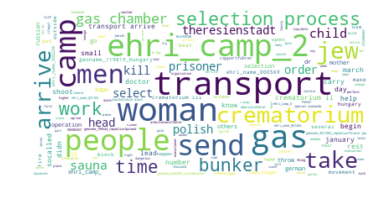

In [38]:
wordcloud = WordCloud(max_font_size=40, max_words=300, background_color="white").generate(" ".join(document_filtered))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
wordcloud.to_file("images/ehri_document_example_wordcloud.png")